## Classification of emotions

It begins with emotion classification on a facial expression dataset, building a model to identify emotions like happiness or sadness. It then applies the model to classify emotions from single images, and finally extends to videos by analyzing multiple frames for dynamic, context-aware predictions.

### Importing the libraries

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab.patches import cv2_imshow
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Conv2D,MaxPooling2D,Flatten,BatchNormalization

### Loading the image

In [2]:
#connect with google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!mkdir /content/my_new_folder

In [5]:
path='/content/my_new_folder/fer_images.zip'
zip_object=zipfile.ZipFile(file=path,mode='r')
zip_object.extractall('./')
zip_object.close()

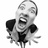

In [6]:
tf.keras.preprocessing.image.load_img('/content/fer2013/train/Angry/1003.jpg')

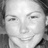

In [7]:
image=tf.keras.preprocessing.image.load_img('/content/fer2013/train/Happy/1.jpg')
image

### Train and test set

In [8]:
training_generator=ImageDataGenerator(rescale=1./255,
                                      rotation_range=7,
                                      horizontal_flip=True,
                                      zoom_range=0.2)
train_dataset=training_generator.flow_from_directory('/content/fer2013/train',
                                                     target_size=(48,48),
                                                     batch_size=16,
                                                     class_mode='categorical',
                                                     shuffle=True)

Found 28709 images belonging to 7 classes.


In [9]:
train_dataset.classes

array([0, 0, 0, ..., 6, 6, 6], dtype=int32)

In [10]:
np.unique(train_dataset.classes,return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6], dtype=int32),
 array([3995,  436, 4097, 7215, 4965, 4830, 3171]))

In [11]:
train_dataset.class_indices

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

<Axes: ylabel='count'>

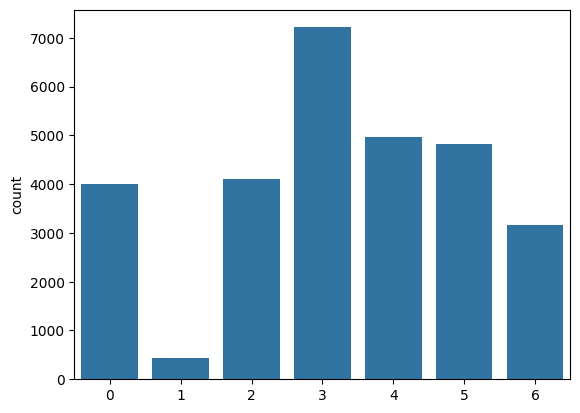

In [12]:
sns.countplot(x=train_dataset.classes)

In [13]:


test_generator=ImageDataGenerator(rescale=1./255)
test_dataset=test_generator.flow_from_directory('/content/fer2013/validation',
                                               target_size=(48,48),
                                                batch_size=1,
                                                class_mode='categorical',
                                                shuffle=False
                                                )

Found 3589 images belonging to 7 classes.


### Building and training the convolutional neural network

In [20]:
num_detectors=32
num_classes=7
width,height=48,48
epochs=5
network=Sequential()
network.add(Conv2D(num_detectors,(3,3),activation='relu',padding='same',input_shape=(width,height,3)))
network.add(BatchNormalization())
network.add(Conv2D(num_detectors,(3,3),activation='relu',padding='same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))

network.add(Conv2D(2*num_detectors,(3,3),activation='relu',padding='same'))
network.add(BatchNormalization())
network.add(Conv2D(2*num_detectors,(3,3),activation='relu',padding='same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))

network.add(Conv2D(2*2*num_detectors,(3,3),activation='relu',padding='same'))
network.add(BatchNormalization())
network.add(Conv2D(2*2*num_detectors,(3,3),activation='relu',padding='same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))

network.add(Conv2D(2*2*2*num_detectors,(3,3),activation='relu',padding='same'))
network.add(BatchNormalization())
network.add(Conv2D(2*2*2*num_detectors,(3,3),activation='relu',padding='same'))
network.add(BatchNormalization())
network.add(MaxPooling2D(pool_size=(2,2)))
network.add(Dropout(0.2))

network.add(Flatten())

network.add(Dense(2*num_detectors,activation='relu'))
network.add(BatchNormalization())
network.add(Dropout(0.2))

network.add(Dense(2*num_detectors,activation='relu'))
network.add(BatchNormalization())
network.add(Dropout(0.2))

network.add(Dense(num_classes,activation='softmax'))
print(network.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 48, 48, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 48, 48, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 48, 48, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 48, 48, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 24, 24, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 12, 12, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,328,743 (5.07 MB)

 Trainable params: 1,326,567 (5.06 MB)

 Non-trainable params: 2,176 (8.50 KB)

None


In [22]:
network.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [23]:
network.fit(train_dataset,epochs=5)

Epoch 1/5
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 955s 527ms/step - accuracy: 0.2137 - loss: 2.0520
Epoch 2/5
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 966s 518ms/step - accuracy: 0.3406 - loss: 1.6674
Epoch 3/5
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 932s 519ms/step - accuracy: 0.4389 - loss: 1.4412
Epoch 4/5
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 982s 519ms/step - accuracy: 0.4959 - loss: 1.3369
Epoch 5/5
1795/1795 ━━━━━━━━━━━━━━━━━━━━ 932s 519ms/step - accuracy: 0.5059 - loss: 1.3053


### Save and loading the model

In [24]:
#saving in json format
model_json=network.to_json()
with open('network_emotions.json','w') as json_file:
  json_file.write(model_json)

In [25]:

from keras.models import save_model
network_saved=save_model(network,'/content/weights_emotions.hdf5')

In [43]:
with open('/content/network_emotions.json','r') as json_file:
  json_saved_model=json_file.read()
json_saved_model

'{"module": "keras", "class_name": "Sequential", "config": {"name": "sequential_2", "trainable": true, "dtype": {"module": "keras", "class_name": "DTypePolicy", "config": {"name": "float32"}, "registered_name": null}, "layers": [{"module": "keras.layers", "class_name": "InputLayer", "config": {"batch_shape": [null, 48, 48, 3], "dtype": "float32", "sparse": false, "name": "input_layer_1"}, "registered_name": null}, {"module": "keras.layers", "class_name": "Conv2D", "config": {"name": "conv2d_8", "trainable": true, "dtype": {"module": "keras", "class_name": "DTypePolicy", "config": {"name": "float32"}, "registered_name": null}, "filters": 32, "kernel_size": [3, 3], "strides": [1, 1], "padding": "same", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "relu", "use_bias": true, "kernel_initializer": {"module": "keras.initializers", "class_name": "GlorotUniform", "config": {"seed": null}, "registered_name": null}, "bias_initializer": {"module": "keras.init

In [45]:
network_loaded = tf.keras.models.model_from_json(json_saved_model)

# Load weights into the model
network_loaded.load_weights('/content/my_new_folder/weights_emotions.hdf5')

# Compile the loaded model
network_loaded.compile(
    loss='categorical_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)

In [46]:
network_loaded.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 48, 48, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 48, 48, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 48, 48, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 48, 48, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 24, 24, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 12, 12, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 1,328,743 (5.07 MB)

 Trainable params: 1,326,567 (5.06 MB)

 Non-trainable params: 2,176 (8.50 KB)

### Evaluating the neural network

In [47]:
network_loaded.evaluate(test_dataset)

  13/3589 ━━━━━━━━━━━━━━━━━━━━ 46s 13ms/step - accuracy: 0.8064 - loss: 0.8271

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3589/3589 ━━━━━━━━━━━━━━━━━━━━ 56s 15ms/step - accuracy: 0.5804 - loss: 1.3395


[1.5148496627807617, 0.5778768658638]

In [49]:
predictions=network_loaded.predict(test_dataset)
predictions

3589/3589 ━━━━━━━━━━━━━━━━━━━━ 67s 19ms/step


array([[9.1399026e-01, 5.2431636e-03, 2.0064991e-02, ..., 7.5534289e-03,
        3.9156079e-02, 1.2308652e-02],
       [8.3489531e-01, 1.3114794e-04, 1.6049378e-01, ..., 8.8334811e-04,
        3.4225918e-03, 1.4467970e-07],
       [9.6874446e-01, 7.4295583e-04, 1.7095279e-02, ..., 1.2566420e-03,
        7.5712618e-03, 4.9269060e-04],
       ...,
       [1.7553564e-03, 4.7019272e-05, 4.1051440e-02, ..., 1.6656757e-03,
        2.9383376e-03, 9.5245779e-01],
       [2.9105283e-03, 4.3033364e-05, 6.9266908e-02, ..., 3.6131248e-01,
        3.1379792e-03, 5.3026128e-01],
       [2.6819440e-02, 2.2662680e-03, 1.1300613e-01, ..., 4.7751740e-03,
        7.1213557e-03, 8.4558278e-01]], dtype=float32)

In [50]:
#for getting the index of max value
predictions=np.argmax(predictions,axis=1)
predictions

array([0, 0, 0, ..., 6, 6, 6])

In [51]:
test_dataset.classes

array([0, 0, 0, ..., 6, 6, 6], dtype=int32)

In [52]:
from sklearn.metrics import accuracy_score
accuracy_score(test_dataset.classes,predictions)

0.5778768459180831

So the accuracy is approximately 57%

In [53]:
test_dataset.class_indices

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

In [54]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(test_dataset.classes,predictions)
cm

array([[276,   8,  53,  14,  64,  71,   5],
       [ 13,  36,   2,   1,   2,   1,   0],
       [ 51,   3, 244,  19,  78,  91,  42],
       [ 10,   2,  16, 775,  46,  18,  12],
       [ 87,  11,  84, 160, 115, 111,  58],
       [ 44,   1,  53,  25, 146, 319,   6],
       [  4,   3,  56,  25,  14,   5, 309]])

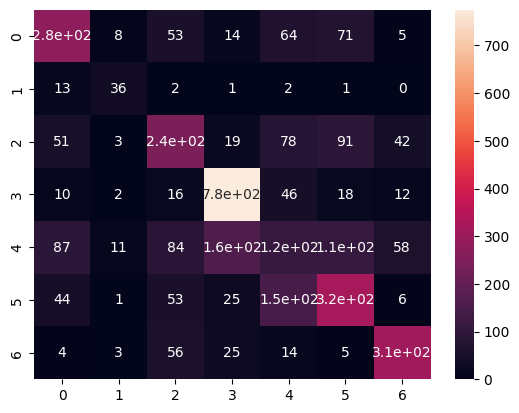

In [55]:
sns.heatmap(cm,annot=True);


In [56]:
from sklearn.metrics import classification_report
print(classification_report(test_dataset.classes,predictions))

              precision    recall  f1-score   support

           0       0.57      0.56      0.57       491
           1       0.56      0.65      0.61        55
           2       0.48      0.46      0.47       528
           3       0.76      0.88      0.82       879
           4       0.25      0.18      0.21       626
           5       0.52      0.54      0.53       594
           6       0.72      0.74      0.73       416

    accuracy                           0.58      3589
   macro avg       0.55      0.57      0.56      3589
weighted avg       0.56      0.58      0.56      3589



### Classifying one single image

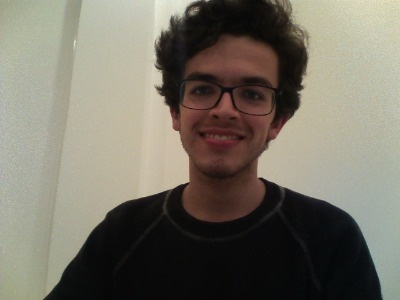

In [74]:
image=cv2.imread('/content/my_new_folder/gabriel.png')
cv2_imshow(image)

For detecting the face

In [75]:
image.shape

(300, 400, 3)

In [76]:
face_detector=cv2.CascadeClassifier('/content/my_new_folder/haarcascade_frontalface_default.xml')


In [77]:
#creating a copy of the image
original_image=image.copy()
faces=face_detector.detectMultiScale(original_image)

In [78]:
faces

array([[162,  40, 128, 128]], dtype=int32)

So face was correctly detected

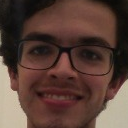

In [79]:
roi=image[40:40+128,162:162+128]
cv2_imshow(roi)

In [80]:
roi.shape

(128, 128, 3)

In [81]:
roi=cv2.resize(roi,(48,48))

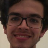

In [82]:
cv2_imshow(roi)

In [83]:
roi.shape

(48, 48, 3)

array([[[ 28,  32,  37],
        [ 22,  28,  34],
        [ 33,  37,  42],
        ...,
        [ 12,  16,  17],
        [ 16,  21,  25],
        [ 16,  25,  30]],

       [[ 27,  31,  36],
        [ 31,  36,  41],
        [ 32,  36,  41],
        ...,
        [ 11,  16,  19],
        [ 13,  19,  24],
        [ 17,  25,  28]],

       [[ 27,  31,  36],
        [ 30,  34,  39],
        [ 26,  30,  35],
        ...,
        [ 12,  17,  20],
        [ 14,  20,  25],
        [ 20,  25,  27]],

       ...,

       [[162, 185, 197],
        [166, 188, 200],
        [166, 188, 200],
        ...,
        [162, 181, 188],
        [162, 182, 188],
        [161, 180, 187]],

       [[160, 184, 196],
        [165, 187, 199],
        [166, 188, 200],
        ...,
        [161, 180, 187],
        [162, 181, 187],
        [161, 180, 187]],

       [[160, 184, 196],
        [163, 187, 199],
        [165, 187, 199],
        ...,
        [160, 179, 186],
        [161, 180, 187],
        [162, 181, 188]]], dtype=uint8)
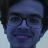

In [84]:
roi

In [68]:
#normalizing values
roi=roi/255
roi

array([[[0.10980392, 0.1254902 , 0.14509804],
        [0.08627451, 0.10980392, 0.13333333],
        [0.12941176, 0.14509804, 0.16470588],
        ...,
        [0.04705882, 0.0627451 , 0.06666667],
        [0.0627451 , 0.08235294, 0.09803922],
        [0.0627451 , 0.09803922, 0.11764706]],

       [[0.10588235, 0.12156863, 0.14117647],
        [0.12156863, 0.14117647, 0.16078431],
        [0.1254902 , 0.14117647, 0.16078431],
        ...,
        [0.04313725, 0.0627451 , 0.0745098 ],
        [0.05098039, 0.0745098 , 0.09411765],
        [0.06666667, 0.09803922, 0.10980392]],

       [[0.10588235, 0.12156863, 0.14117647],
        [0.11764706, 0.13333333, 0.15294118],
        [0.10196078, 0.11764706, 0.1372549 ],
        ...,
        [0.04705882, 0.06666667, 0.07843137],
        [0.05490196, 0.07843137, 0.09803922],
        [0.07843137, 0.09803922, 0.10588235]],

       ...,

       [[0.63529412, 0.7254902 , 0.77254902],
        [0.65098039, 0.7372549 , 0.78431373],
        [0.65098039, 0

In [86]:
#Adding  a new dimension using batch format
roi=np.expand_dims(roi,axis=0)
roi.shape

(1, 48, 48, 3)

In [93]:
probs=network_loaded.predict(roi)
probs

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


array([[1.0000000e+00, 8.6344095e-35, 3.2496525e-09, 0.0000000e+00,
        4.0337432e-31, 1.8300544e-18, 0.0000000e+00]], dtype=float32)

In [91]:
result=np.argmax(probs)
result

0

In [92]:
test_dataset.class_indices

{'Angry': 0,
 'Disgust': 1,
 'Fear': 2,
 'Happy': 3,
 'Neutral': 4,
 'Sad': 5,
 'Surprise': 6}

### Classifying multiple images

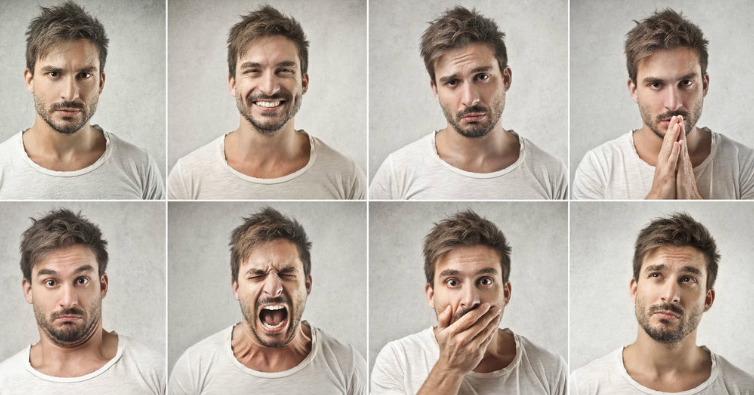

In [95]:
image=cv2.imread('/content/my_new_folder/faces_emotions.png')
cv2_imshow(image)

So,our goal is to detect the emotion of each faces

In [96]:
faces=face_detector.detectMultiScale(image)
faces

array([[224,  35,  90,  90],
       [625,  49,  91,  91],
       [ 23,  41,  92,  92],
       [420,  43,  97,  97],
       [420, 242,  97,  97],
       [ 18, 243,  98,  98],
       [229, 242,  85,  85],
       [627, 241,  91,  91]], dtype=int32)

So it detect all faces correctly

In [98]:
test_dataset.class_indices.keys()

dict_keys(['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise'])

In [99]:
emotions=['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


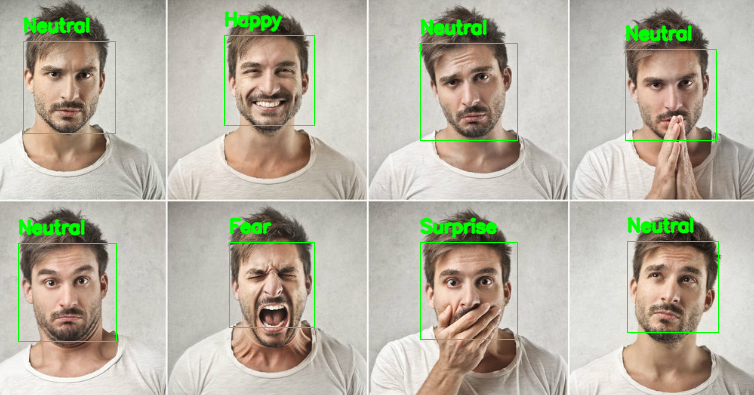

In [103]:
for (x,y,w,h) in faces:
  cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),1)#drawing rectangles around faces
  roi=image[y:y+h,x:x+w] #extracting only faces
  roi=cv2.resize(roi,(48,48))#resizing the image
  roi=roi/255 #normalizing the image
  roi=np.expand_dims(roi,axis=0)
  prediction=network_loaded.predict(roi)
  #print(prediction)
  cv2.putText(image,emotions[np.argmax(prediction)],(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,0.6,(0,255,0),2,cv2.LINE_AA) #Inserting text in the image
cv2_imshow(image)

So it detects the emotions in each images

### Classifying emotions in videos

In [107]:
cap=cv2.VideoCapture('/content/my_new_folder/emotion_test01.mp4')
connected,video=cap.read()
print(connected,video.shape)

True (360, 640, 3)


So the video is correctly loaded and other parameter denote the shape of video

In [110]:
#define a path to save the video
save_path='/content/my_new_folder/emotion_test01_result.avi'
fourcc=cv2.VideoWriter_fourcc(*'XVID')
fps=24 #frames per second
output_video=cv2.VideoWriter(save_path,fourcc,fps,(video.shape[1],video.shape[2]))

In [111]:
while (cv2.waitKey(1)<0):
  connected,frame=cap.read()
  if not connected:
    break
  faces=face_detector.detectMultiScale(frame,scaleFactor=1.2,minNeighbors=5,minSize=(30,30))
  if len(faces)>0:
    for (x,y,w,h) in faces:
      frame=cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,0),2)
      roi=frame[y:y+h,x:x+w]
      roi=cv2.resize(roi,(48,48))
      roi=roi/255
      roi=np.expand_dims(roi,axis=0)
      prediction=network_loaded.predict(roi)
      if prediction is not None:
        result=np.argmax(prediction)
        cv2.putText(frame,emotions[result],(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,0.5,(255,255,255),1,cv2.LINE_AA)
  cv2_imshow(frame)
  output_video.write(frame)
print('End')
output_video.release()
cv2.destroyAllWindows()


End


Hence the emotions in the video are correctly classfied by considering it as a number of frames and saved it to an avi format

